In [54]:
import sys
sys.path.append('../')

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from datetime import datetime, date, time

from scripts.standarise_data import count_spectrums, index_inchikey

from matchms.importing import load_from_msp

MSrawdata='xaf' #sample data
data_path = '../data/processed/MS2MassBank/'
data_path_sim = '../data/processed/CosineSimilarity/'

In [ ]:
spectrums=[]
spectrums = list(load_from_msp(data_path+MSrawdata+"_transformed.msp"))

In [3]:
#Calculate cosine scores using the CosineGreedy function.
#Two peaks are matched if their m/z ratios lie in a certain tolerance

from matchms import calculate_scores
from matchms.similarity import CosineGreedy
similarity_measure = CosineGreedy(tolerance=0.01)
print('Start: ' + datetime.now().strftime('%H:%M:%S'))
scores = calculate_scores(spectrums, spectrums, similarity_measure, is_symmetric=True)
print('End: ' + datetime.now().strftime('%H:%M:%S'))

Start: 11:35:13
End: 11:35:25


In [90]:
scores_array = scores.scores.to_array()

In [121]:
#Importing cosine scores
#dfcosines = pd.read_csv(data_path_sim+'cosine_scores_'+MSrawdata+'.csv', sep = ';',header=None)
#df_scores_array=dfcosines.to_numpy()

### Scatter Plotting cosine values

In [72]:
lower_triangle = scores_array[np.tril_indices(scores_array.shape[0], k=-1)].tolist()
cosine_list=[lower_triangle[c][0] for c in range(len(lower_triangle))]
matches_list=[lower_triangle[c][1] for c in range(len(lower_triangle))]
cosine_ij=pd.DataFrame({'cosine':cosine_list, 'matches':matches_list})

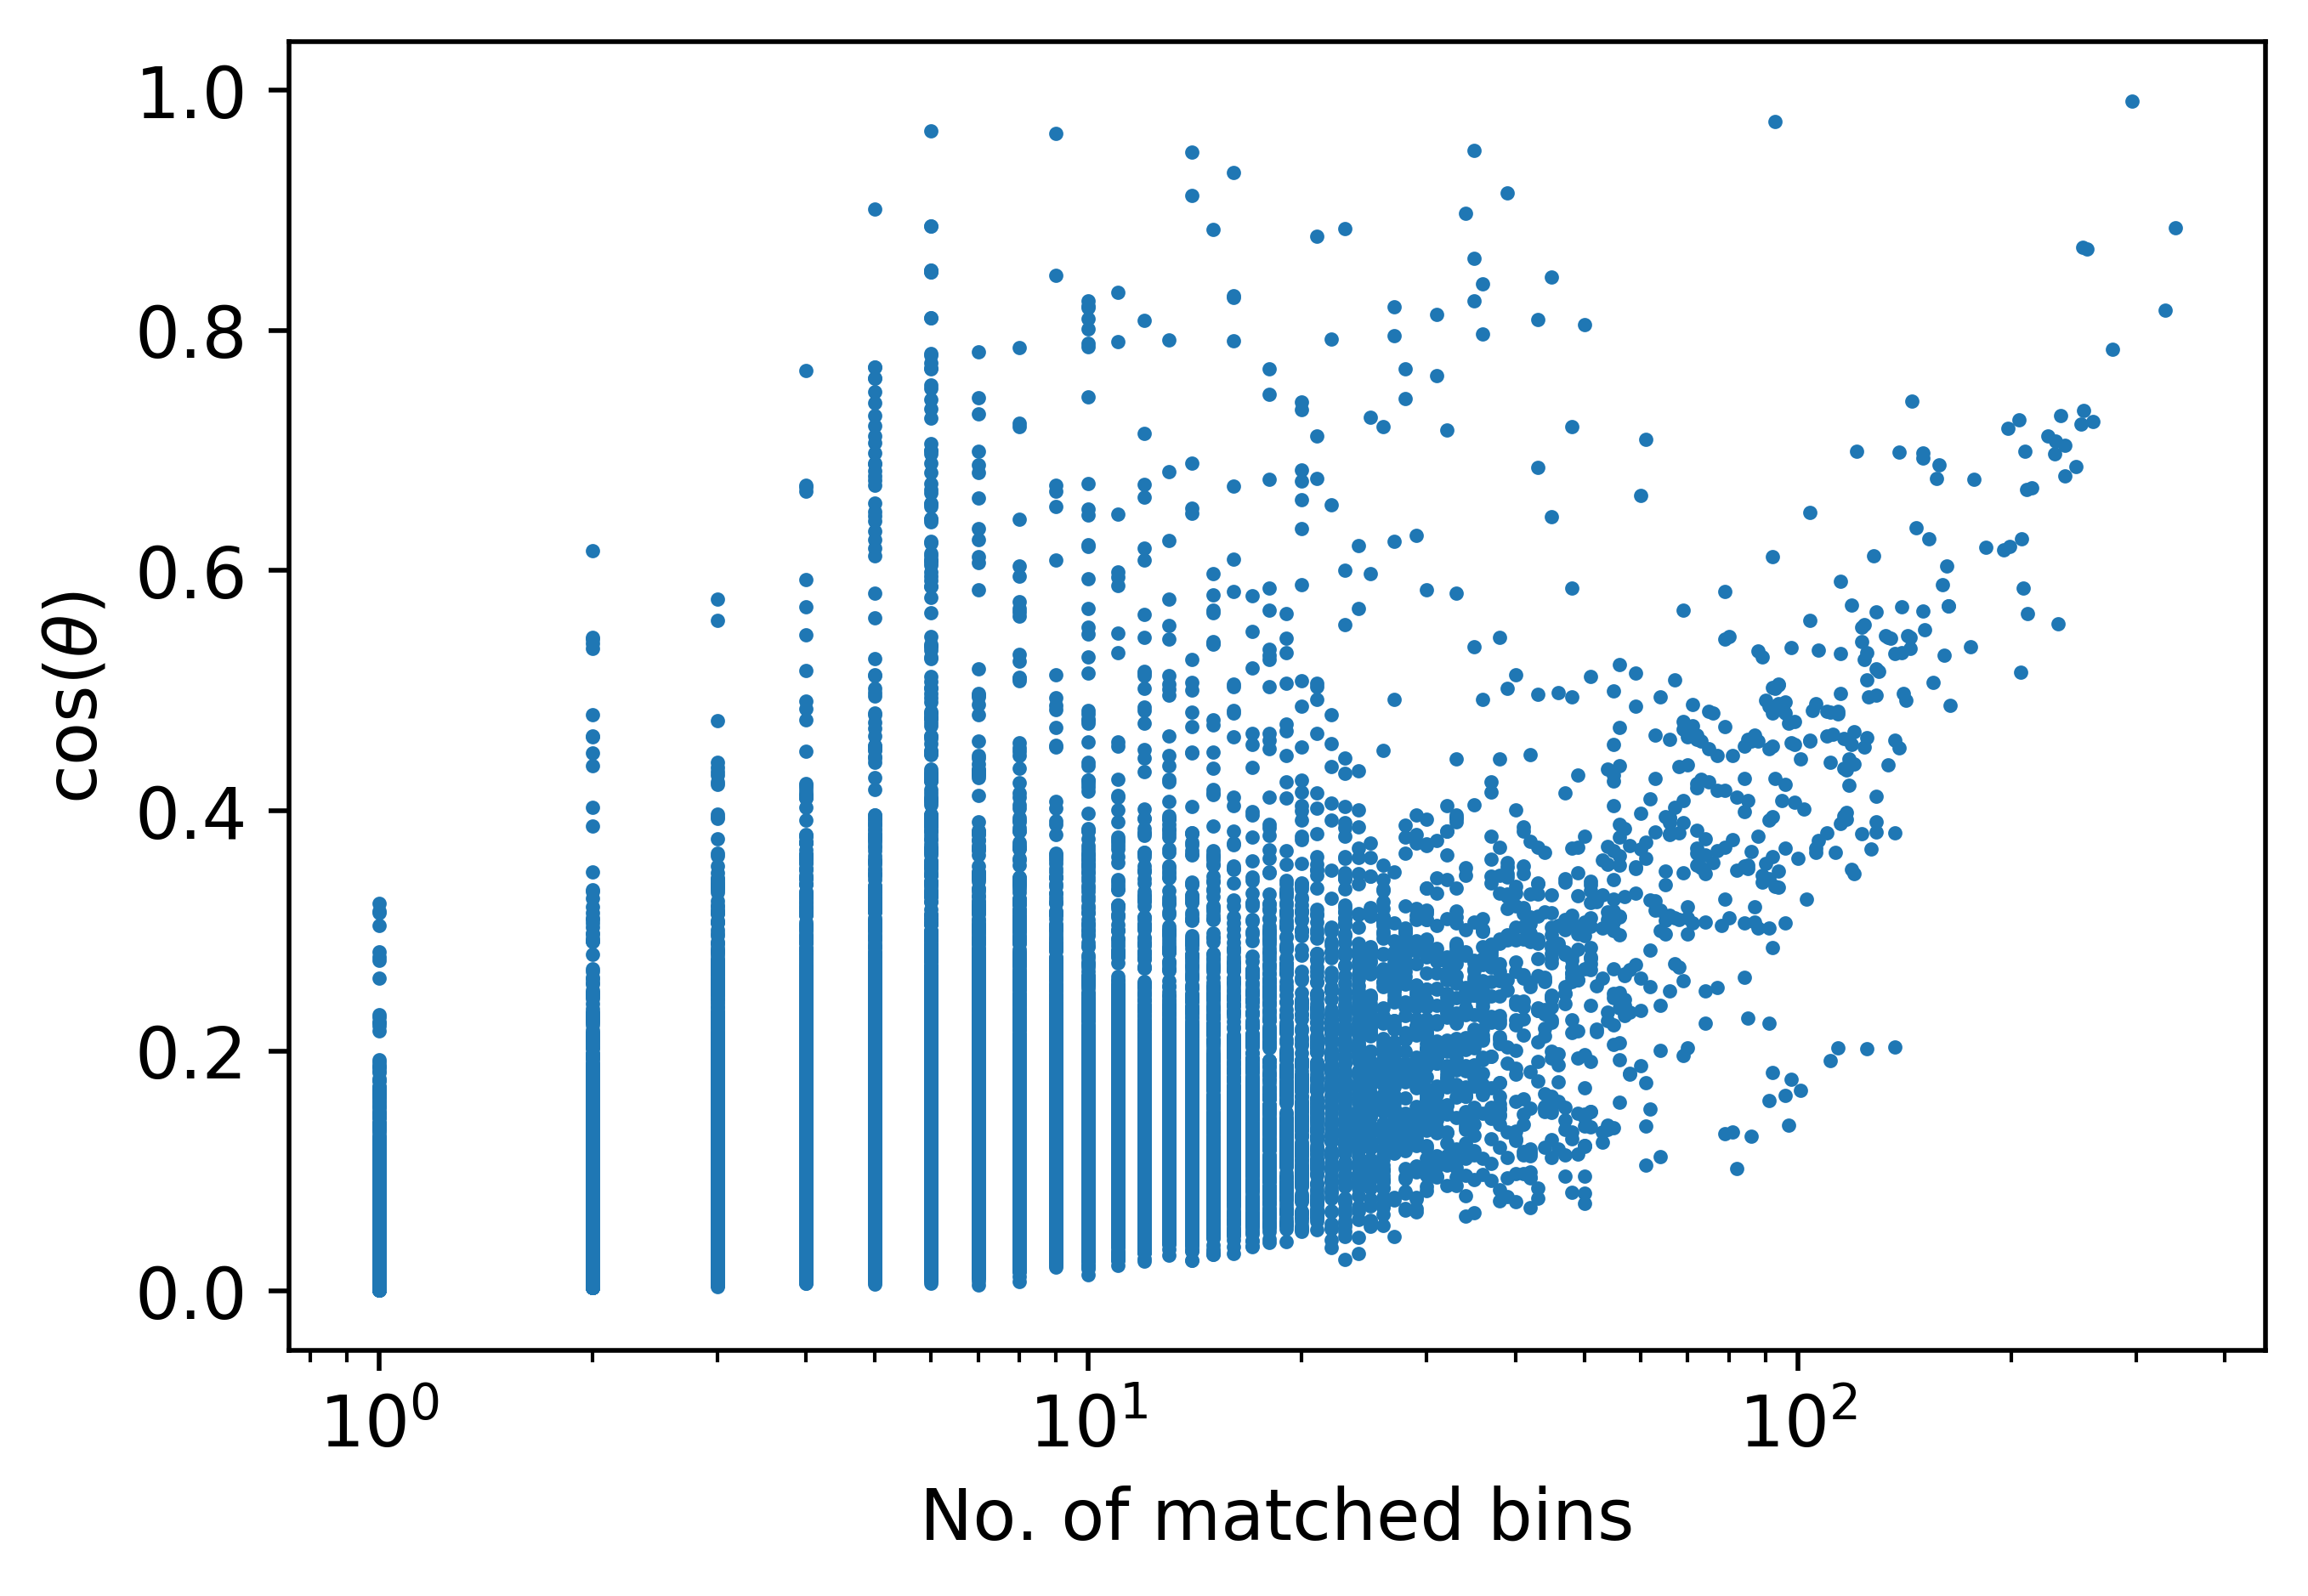

In [73]:
#cosine_ij=cosine_ij.sample(frac=0.01, random_state=42)

x=cosine_ij['matches']
y=cosine_ij['cosine']

plt.figure(figsize=(6,4), dpi=500)
plt.scatter(x,y, s=2)
plt.xlabel('No. of matched bins',  fontsize=12)
plt.ylabel(r'$\cos(\theta)$', fontsize=12)
plt.xscale('log')
plt.tick_params(axis='both', labelsize=12)
#plt.xticks(range(0, max(x)+1, 10))
#plt.yticks(range(0, int(max(y))+10, 50))
#plt.savefig('img/cosine_vs_matches.png', bbox_inches='tight')
plt.show()

In [7]:
# Sum matches and sum cosine per inchikey over the whole dataset.
# inchikeys
inchikeys=[s.get('inchikey') for s in spectrums]
# matches budget
np.fill_diagonal(scores_array["CosineGreedy_matches"],0)
sum_all_matches = np.sum(scores_array["CosineGreedy_matches"], axis=0).tolist() 
# cosine budget
np.fill_diagonal(scores_array["CosineGreedy_score"],0)
sum_all_cosine= np.sum(scores_array["CosineGreedy_score"], axis=0).tolist() 
score_values=pd.DataFrame({'sum_all_matches':sum_all_matches, 'sum_all_cosine':sum_all_cosine},index=inchikeys)
score_values

,sum_all_matches,sum_all_cosine
GOJCZVPJCKEBQV-UHFFFAOYSA-N,831,16.925451
YHMYGUUIMTVXNW-UHFFFAOYSA-N,621,15.145294
ZQEIXNIJLIKNTD-UHFFFAOYSA-N,1696,19.389043
RXLOZRCLQMJJLC-UHFFFAOYSA-N,910,12.884342
GNOIPBMMFNIUFM-UHFFFAOYSA-N,64,1.693926
...,...,...
MBMQEIFVQACCCH-QBODLPLBSA-N,11,0.343142
QCHFTSOMWOSFHM-WPRPVWTQSA-N,129,2.798025
ZYGHJZDHTFUPRJ-UHFFFAOYSA-N,573,19.459959
SNICXCGAKADSCV-JTQLQIEISA-N,658,13.136012


In [8]:
# frequency
spectrums_per_inchikey=pd.read_csv(data_path+'frequency_inchikeys_before_merging.csv')
spectrums_per_inchikey.set_index('inchikey',inplace=True)
# total peaks combined
peaks_per_inchikey=pd.read_csv(data_path+'len_peaks_after_merging.csv')
peaks_per_inchikey.set_index('inchikey',inplace=True)

metrics_cosine=spectrums_per_inchikey.merge(peaks_per_inchikey, left_index=True, right_index=True, how='right')
metrics_cosine=metrics_cosine.merge(score_values, left_index=True, right_index=True, how='right')
metrics_cosine



,Frequency,num_peaks,sum_all_matches,sum_all_cosine
GOJCZVPJCKEBQV-UHFFFAOYSA-N,6,27,831,16.925451
YHMYGUUIMTVXNW-UHFFFAOYSA-N,6,19,621,15.145294
ZQEIXNIJLIKNTD-UHFFFAOYSA-N,6,63,1696,19.389043
RXLOZRCLQMJJLC-UHFFFAOYSA-N,6,58,910,12.884342
GNOIPBMMFNIUFM-UHFFFAOYSA-N,6,13,64,1.693926
...,...,...,...,...
MBMQEIFVQACCCH-QBODLPLBSA-N,1,4,11,0.343142
QCHFTSOMWOSFHM-WPRPVWTQSA-N,5,25,129,2.798025
ZYGHJZDHTFUPRJ-UHFFFAOYSA-N,3,8,573,19.459959
SNICXCGAKADSCV-JTQLQIEISA-N,3,19,658,13.136012


QC: Verifying the table. frequency and num_peaks directly in MassBank.eu. For scores:

In [9]:
#SNICXCGAKADSCV-JTQLQIEISA-N 	3 	19 	658 	13.136012
index_inchikey(spectrums,'SNICXCGAKADSCV-JTQLQIEISA-N')

index: 592


In [10]:
scores_one = calculate_scores(spectrums, [spectrums[592]], similarity_measure)
scores_one_array=scores_one.scores.to_array()
scores_one_array["CosineGreedy_score"]
float(np.sum(scores_one_array["CosineGreedy_score"], axis=0))-1

13.136011924363846

In [11]:
scores_one_array["CosineGreedy_matches"]
int(np.sum(scores_one_array["CosineGreedy_matches"], axis=0))-len(spectrums[592].peaks)

658

The metrics_cosine table was verified for indexes and values, then saving and plotting.

In [12]:
metrics_cosine.to_csv(data_path+'metrics_cosine.csv')

## Exploring cosine individual values and their sum  

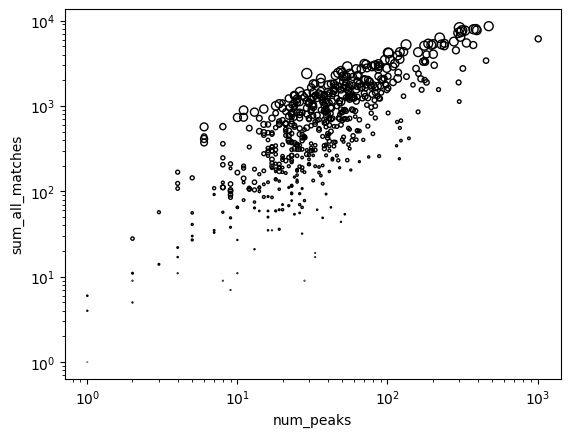

In [13]:
#For a sample
#metrics_cosine=metrics_cosine.sample(frac=0.1, random_state=42)
#For all data
x=metrics_cosine['num_peaks']
y=metrics_cosine['sum_all_matches']
size=metrics_cosine['sum_all_cosine']
plt.scatter(x, y, s=size,facecolors='none',edgecolors='black')
plt.xlabel('num_peaks')
plt.ylabel('sum_all_matches')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [14]:
#Intervals distribution
# Define the intervals
interval_width = 0.1
intervals = np.arange(0, 1.0 + interval_width, interval_width)

# Create the frequency table
frequency_table, _ = np.histogram(cosine_list, bins=intervals)

# Print the frequency table
for interval, frequency in zip(intervals[:-1], frequency_table):
    print(f"{interval:.1f}-{interval+interval_width:.1f}: {frequency}")

0.0-0.1: 163021
0.1-0.2: 8888
0.2-0.3: 2583
0.3-0.4: 942
0.4-0.5: 312
0.5-0.6: 160
0.6-0.7: 108
0.7-0.8: 63
0.8-0.9: 34
0.9-1.0: 10


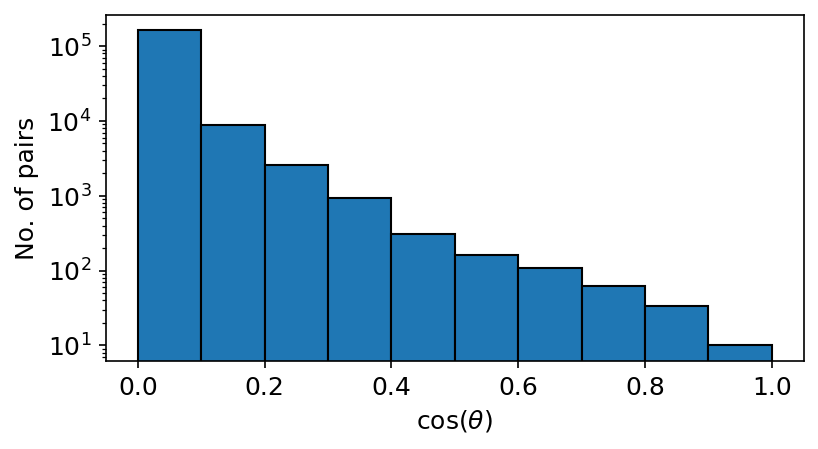

In [15]:
ordered_values = sorted(cosine_list)

plt.figure(figsize=(6,3), dpi=150)

bins = np.arange(0, 1.01, 0.1)
plt.hist(ordered_values, bins=bins, edgecolor='black', density=False)

plt.xlabel(r'$\cos(\theta)$', fontsize=12)
plt.ylabel('No. of pairs', fontsize=12)

#plt.semilogy()
plt.tick_params(axis='both', labelsize=12) 
plt.semilogy()
#plt.savefig('cosine_pairs_log_2.pdf', bbox_inches='tight')

# Show the plot
plt.show()

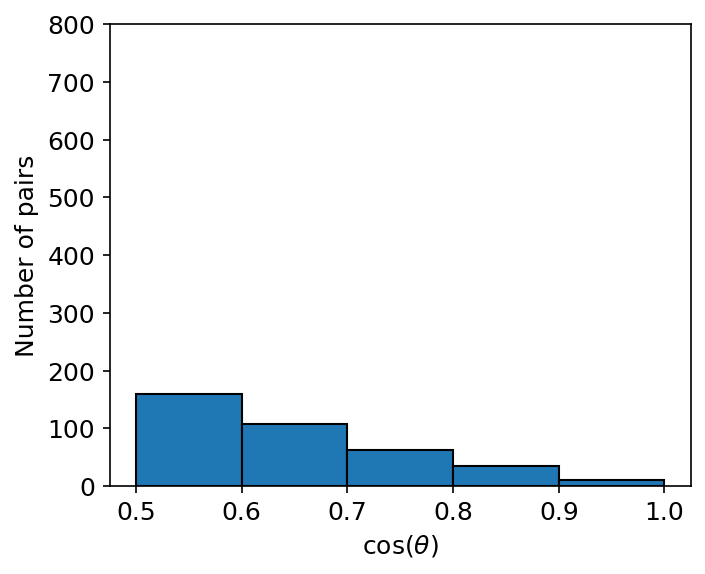

In [16]:
ordered_values = sorted(cosine_list)

plt.figure(figsize=(5,4), dpi=150)
bins = np.arange(0.5, 1.01, 0.1)
plt.hist(ordered_values, bins=bins, edgecolor='black', density=False)

plt.xlabel(r'$\cos(\theta)$', fontsize=12)
plt.ylabel('Number of pairs', fontsize=12)

plt.yticks(range(0,900,100))

#plt.semilogy()

plt.tick_params(axis='both', labelsize=12) 
#plt.savefig('cosine_pairs_05.pdf', bbox_inches='tight')

plt.show()

QC: Verifying the index. Calculating the cosine for some pairs and then comparing it with values in the dataframe df_cosine

In [17]:
df_cosine = pd.DataFrame(scores_array["CosineGreedy_score"])
inchikeys=[s.get('inchikey') for s in spectrums]
df_cosine.columns = inchikeys
df_cosine.head()

,GOJCZVPJCKEBQV-UHFFFAOYSA-N,YHMYGUUIMTVXNW-UHFFFAOYSA-N,ZQEIXNIJLIKNTD-UHFFFAOYSA-N,RXLOZRCLQMJJLC-UHFFFAOYSA-N,GNOIPBMMFNIUFM-UHFFFAOYSA-N,YWTYJOPNNQFBPC-UHFFFAOYSA-N,XBZBRCVCSVLJJZ-UHFFFAOYSA-N,KCIDXSZMKJKCSV-UHFFFAOYSA-N,WMBWREPUVVBILR-WIYYLYMNSA-N,OBZIQQJJIKNWNO-UHFFFAOYSA-N,...,BLGXFZZNTVWLAY-SCYLSFHTSA-N,LTMHDMANZUZIPE-PUGKRICDSA-N,OLOOJGVNMBJLLR-UHFFFAOYSA-N,GFFGJBXGBJISGV-UHFFFAOYSA-N,XBPCUCUWBYBCDP-UHFFFAOYSA-N,MBMQEIFVQACCCH-QBODLPLBSA-N,QCHFTSOMWOSFHM-WPRPVWTQSA-N,ZYGHJZDHTFUPRJ-UHFFFAOYSA-N,SNICXCGAKADSCV-JTQLQIEISA-N,XJHDMGJURBVLLE-BOCCBSBMSA-N
0,0.000000,0.030293,0.0,0.017535,0.0,0.010038,0.072288,0.00000,0.000000,0.039168,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.028808
1,0.030293,0.000000,0.0,0.000000,0.0,0.073335,0.000000,0.00000,0.114827,0.020448,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.012343,0.000000
2,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.007380,...,0.122258,0.0,0.016152,0.000000,0.000000,0.0,0.0,0.073456,0.302311,0.058459
3,0.017535,0.000000,0.0,0.000000,0.0,0.041357,0.000000,0.04548,0.000000,0.004406,...,0.000000,0.0,0.000000,0.022908,0.095918,0.0,0.0,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.039343,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [18]:
cosine_greedy = CosineGreedy(tolerance=0.1)
cosine_greedy.pair(spectrums[5],spectrums[1])

array((0.07333485, 6), dtype=[('score', '<f8'), ('matches', '<i8')])

In [19]:
spectrums[5].get('inchikey')

'YWTYJOPNNQFBPC-UHFFFAOYSA-N'

Then, continuing with the sum cosine per inchikey. This could show what compounds relate more with the rest of the dataset.  

In [20]:
sum_cosine = df_cosine.sum().tolist()
int_cosine = np.array(sum_cosine)/max(sum_cosine)
sorted(sum_cosine, reverse=True)[:10]

[54.77036081624234,
 52.21293723394488,
 49.59465290987809,
 46.69125455707581,
 46.53077236842876,
 46.15085382079649,
 45.91975726947138,
 45.38860670856371,
 43.613096232186344,
 43.29050387919962]

In [21]:
sorted(int_cosine, reverse=True)[:10]

[1.0,
 0.9533064317235783,
 0.905501664965673,
 0.8524912719441015,
 0.8495611800795349,
 0.8426246081459134,
 0.8384052356991908,
 0.8287074620677606,
 0.7962901025704532,
 0.790400195179318]

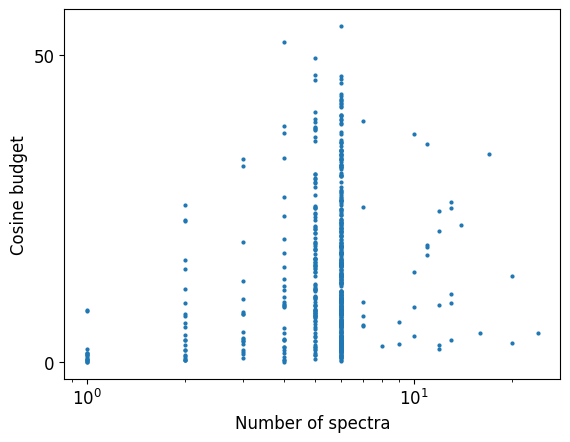

In [22]:
x=metrics_cosine['Frequency']
y=metrics_cosine['sum_all_cosine']
plt.style.use('_classic_test_patch')
plt.scatter(x, y, s=4)
plt.xlabel('Number of spectra',  fontsize=12)
plt.ylabel('Cosine budget', fontsize=12)
#plt.title('Sum of cosine similarity vs number of peaks')
plt.xticks(range(0, max(x)+1, 10))
plt.yticks(range(0, int(max(y))+10, 50))
plt.tick_params(axis='both', labelsize=12)
plt.semilogx()
#plt.savefig('sum_cosine_vs_spectra.pdf', bbox_inches='tight')
plt.show()

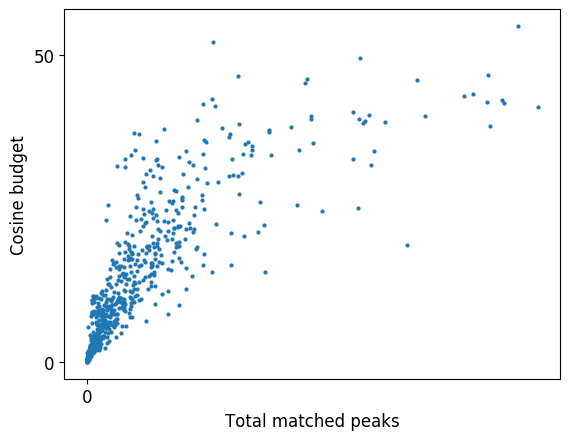

In [23]:
x=metrics_cosine['sum_all_matches']
y=metrics_cosine['sum_all_cosine']

plt.style.use('_classic_test_patch')
plt.scatter(x, y, s=4)
plt.xlabel('Total matched peaks', fontsize=12)
plt.ylabel('Cosine budget', fontsize=12)
plt.xticks(range(0, max(x)+10000, 40000))
plt.yticks(range(0, int(max(y))+10, 50))
#plt.semilogx()
plt.tick_params(axis='both', labelsize=12) 
#plt.savefig('img/sum_cosine_vs_matched_peaks.pdf', bbox_inches='tight')
plt.show()

Clustermap

/home/pc32/code_projects/mnet/mnet_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/pc32/code_projects/mnet/mnet_env/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/pc32/code_projects/mnet/mnet_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/pc32/code_projects/mnet/mnet_env/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method

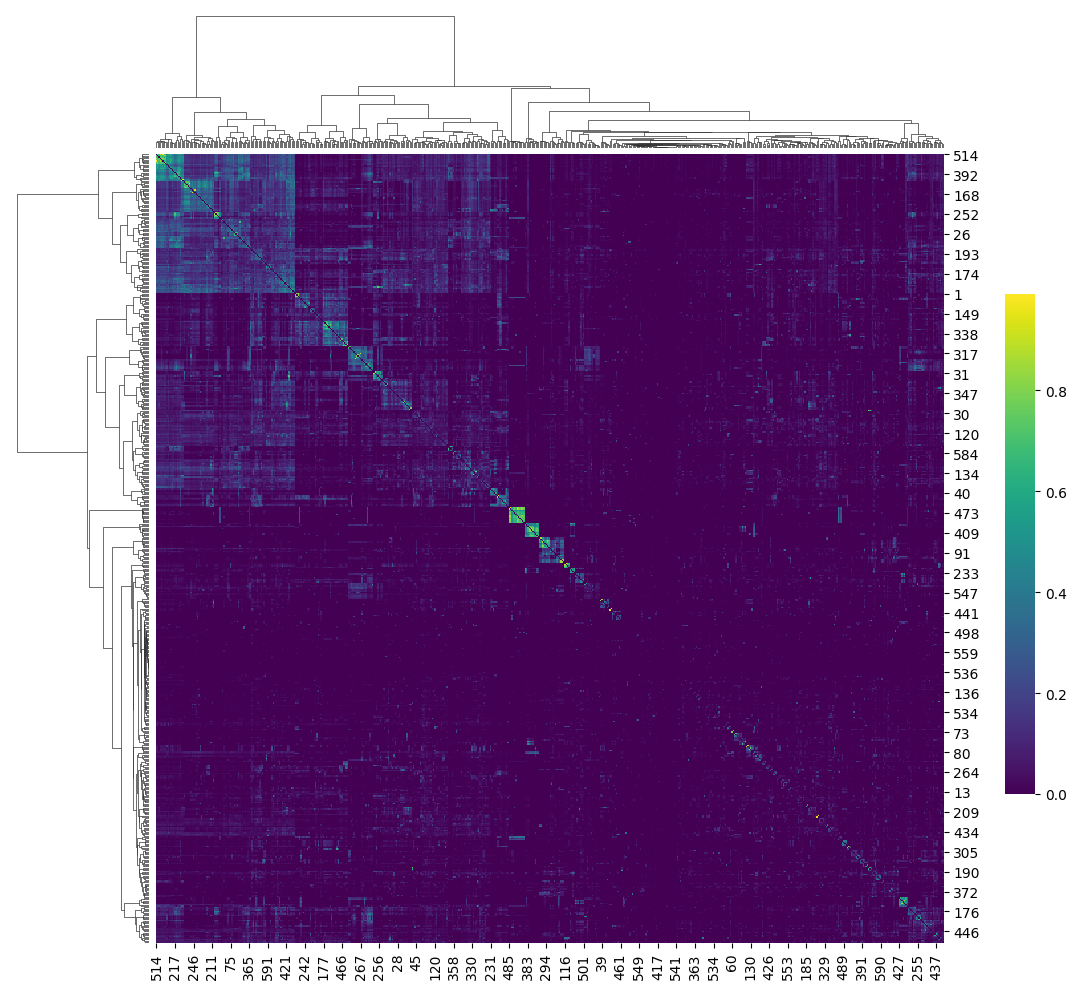

In [50]:
%matplotlib inline
import seaborn as sns

# calculate dendrogram and cluster assignments
linkage = sns.clustermap(df_cosine.to_numpy(), cmap='viridis',  method='ward',
                          figsize=(10, 10), dendrogram_ratio=(.15, .15), cbar_pos=(1.01, .2, .03, .5))

# remove axis labels and ticks
#linkage.ax_row_dendrogram.set(xticks=[])
#linkage.ax_col_dendrogram.set(yticks=[])
#linkage.ax_heatmap.set(xticks=[], yticks=[])